# **[Project] Cancer Subtype Classification**

# Introduction

The [TCGA Kidney Cancers Dataset](https://archive.ics.uci.edu/dataset/892/tcga+kidney+cancers) is a bulk RNA-seq dataset that contains transcriptome profiles (i.e., gene expression quantification data) of patients diagnosed with three different subtypes of kidney cancers.
This dataset can be used to make predictions about the specific subtype of kidney cancers given the normalized transcriptome profile data.

The normalized transcriptome profile data is given as **TPM** and **FPKM** for each gene.

> TPM (Transcripts Per Million) and FPKM (Fragments Per Kilobase Million) are two common methods for quantifying gene expression in RNA sequencing data.
> They both aim to account for the differences in sequencing depth and transcript length when estimating gene expression levels.
>
> **TPM** (Transcripts Per Million):
> - TPM is a measure of gene expression that normalizes for both library size (sequencing depth) and transcript length.
> - The main idea behind TPM is to express the abundance of a transcript relative to the total number of transcripts in a sample, scaled to one million.
>
> **FPKM** (Fragments Per Kilobase Million):
> - FPKM is another method for quantifying gene expression, which is commonly used in older RNA-seq analysis pipelines. It's similar in concept to TPM but differs in the way it's calculated.
> - FPKM also normalizes for library size and transcript length, but it measures gene expression as the number of fragments (i.e., reads) per kilobase of exon model per million reads.
>
> TPM is generally considered more robust to variations in library size, making it a preferred choice in many modern RNA-seq analysis workflows.

We provide one dataset for each kidney cancer subtype:

- [TCGA-KICH](https://portal.gdc.cancer.gov/projects/TCGA-KICH): kidney chromophobe (renal clear cell carcinoma)
- [TCGA-KIRC](https://portal.gdc.cancer.gov/projects/TCGA-KIRC): kidney renal clear cell carcinoma
- [TCGA-KIRP](https://portal.gdc.cancer.gov/projects/TCGA-KIRP): kidney renal papillary cell carcinoma

> This and _much_ more data is openly available on the [NCI Genomic Data Commons (GDC) Data Portal](https://portal.gdc.cancer.gov/).

# Data access

There are two ways to access the data: via the TNT homepage or the GDC Data Portal.

## Download from the TNT homepage (_recommended_)

The download from the TNT homepage is straightforward:

In [1]:
# ! wget http://www.tnt.uni-hannover.de/edu/vorlesungen/AMLG/data/project-cancer-classification.tar.gz
# ! tar -xzvf project-cancer-classification.tar.gz
# ! mv -v project-cancer-classification/ data/
# ! rm -v project-cancer-classification.tar.gz

In the `data/` folder you will now find many files in the [TSV format](https://en.wikipedia.org/wiki/Tab-separated_values) ([CSV](https://en.wikipedia.org/wiki/Comma-separated_values)-like with tabs as delimiter) containing the normalized transcriptome profile data.

To start, you can read a TSV file into a [pandas](https://pandas.pydata.org) [`DataFrame`](pandas dataframe to dict) using the [`pandas.read_csv()`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html#pandas-read-csv) function with the `sep` parameter set to `\t`:

## ML Pipeline (Data Preprocessing, Data Visualization, Feature Selection, Algorithm Selection, Hyperparameter Optimization)

Our ML pipeline includes the following necessary steps:
1. Data Preprocessing & Visualization: Understand the data & Preprocess it in a useful format
2. Feature Selection: Select the most important features
3. Algorithm Selection: Select the ML algorithm
4. Hyperparameter Optimization: Optimize the hyperparameter of the ML algorithm

## Data Preprocessing & Visualization

Before we applying some ML algorithms, we have to preprocess our data into numerical/categorical values so that the ML algorithms can handle these values.

Each sample contains the following multiple rows:
 - **gene_id:** Id of the specific gene
 - **gene_name:** Name of the specific gene
 - **gene_type:** Type of the specific gene
 - **unstranded:** Unstranded expression values for the corresponding gene
 - **stranded_first:** Expression values for the first (sense) strand of the gene
 - **stranded_second:** Expression values for the second (antisense) strand of the gene
 - **tpm_unstranded:** Transcripts per Million
 - **fpkm_unstranded:** Fragments per Kilobase of transcript per Million mapped reads
 - **fpkm_uq_unstranded:** Upper quartile fragments per Kilobase of transcripts per Million mapped reads
 - **class_index:** The label of the corresponding subtype of kidney cancer and columns

We suppose to use **tpm_unstranded** for further analysis.

The following example shows how each sample is constructed:

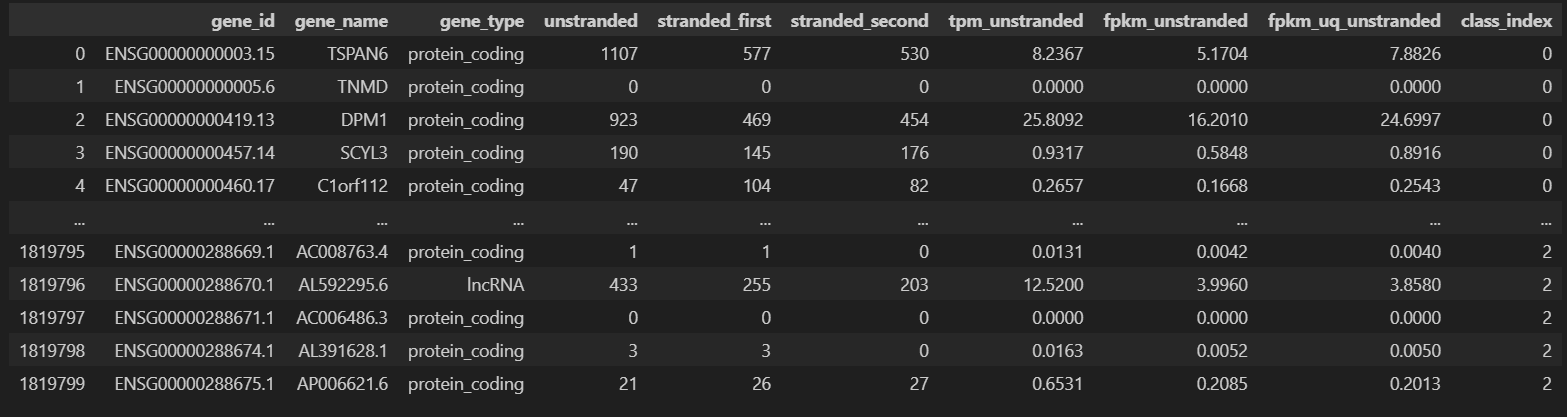

In [2]:
from typing import Optional, Union, Type
import pandas as pd
import glob
import os

def load_profile_data(file_path: str, remove_header: bool = True) -> pd.DataFrame:
    """
    Loads a specific RNA-sequence data (one sample).

    Args:
        file_path (str):
            Specific path of the file

        remove_header (bool, optional):
            Controls if the header (first four rows of df) should be removed

    Returns:
        pd.DataFrame:
            RNA-sequence data of one sample
    """
    
    # Read the TSV file into a DataFrame
    df = pd.read_csv(filepath_or_buffer=file_path, sep="\t")
    
    # Remove Multi-Key Index and make it tabular
    df.reset_index(inplace=True)

    # Rename the new columns level_i into the corresponding columns
    df.rename(columns={
        "level_0": "gene_id",
        "level_1": "gene_name",
        "level_2": "gene_type",
        "level_3": "unstranded",
        "level_4": "stranded_first",
        "level_5": "stranded_second",
        "level_6": "tpm_unstranded",
        "level_7": "fpkm_unstranded",
        "# gene-model: GENCODE v36": "fpkm_uq_unstranded",
    }, inplace=True)

    # Remove the first row
    df = df.iloc[1:]
    
    # Change the dtypes of specific columns
    df["unstranded"] = df["unstranded"].astype(int)
    df["stranded_first"] = df["stranded_first"].astype(int)
    df["stranded_second"] = df["stranded_second"].astype(int)
    df["tpm_unstranded"] = df["tpm_unstranded"].astype(float)
    df["fpkm_unstranded"] = df["fpkm_unstranded"].astype(float)
    df["fpkm_uq_unstranded"] = df["fpkm_uq_unstranded"].astype(float)
    
    if remove_header:
        # Case: Remove the header rows
        df = df.iloc[4:]
    
    # Reset the index
    df.reset_index(drop=True, inplace=True)
    return df

def simplify_dataset(
    df: pd.DataFrame, 
    categorical_column: str = "gene_name",
    continuous_column: str = "tpm_unstranded",
    n_genes: int = 60660,
) -> pd.DataFrame:
    """
    Simplifies the dataset by removing all columns except the given continuous column
    and renames each column by the categorical column.

    Args:
        df (pd.DataFrame):
            The dataframe we want to simplify
        
        categorical_column (str, optional):
            The labels of the new columns
        
        continuous_column (str, optional): 
            The column we want to keep
        
        n_genes (int, optional):
            The number of genes we want to keep (60660 := all genes)

    Returns:
        pd.DataFrame:
            The resulting dataframe
    """
    assert 1 <= n_genes <= 60660, f"Illegal n_genes {n_genes}. The argument should be higher or equal to 1!"
    
    # Transpose the given (N, 1) dataset to (1, N)
    new_df =  pd.DataFrame(df[continuous_column][:n_genes])
    new_df = new_df.transpose()
    
    # Rename the columns to the new ones
    new_df.columns = df[categorical_column][:n_genes].to_numpy()
    
    # Reset the indices
    new_df.reset_index(drop=True, inplace=True)
    return new_df

def load_cancer_classification_dataset(
    data_path: str, 
    continuous_column: str = "tpm_unstranded",
    n_genes: int = 60660,
    remove_header: bool = True,
    n_samples: Optional[int] = None,
) -> pd.DataFrame:
    """
    Loads the entire cancer classification dataset.

    Args:
        data_path (str):
            Specific path of the dataset
        
        remove_header (bool, optional):
            Controls if the header (first four rows of df) should be removed for each instance
        
        n_samples (int, optional): 
            Number of instances for each class
    
    Returns:
        pd.DataFrame:
            Cancer classification dataset
    """
    datasets = ["tcga-kich-geq", "tcga-kirc-geq", "tcga-kirp-geq"]
    tsv_files = []
    dfs = []
    ys = []
    root_dir = os.path.join(os.getcwd(), data_path)

    # Get the paths of all tsv files
    for i, dataset in enumerate(datasets):
        dataset_path = os.path.join(root_dir, dataset)
        paths = glob.glob(os.path.join(dataset_path, "*/*.tsv"))
        
        if n_samples:
            tsv_files += paths[:n_samples]
            ys += [i] * len(paths[:n_samples])
        else:
            tsv_files += paths
            ys += [i] * len(paths)

    # Load the data from all tsv files
    for i, tsv_file in enumerate(tsv_files):
        df = load_profile_data(tsv_file, remove_header)
        df = simplify_dataset(df, continuous_column=continuous_column, n_genes=n_genes)
        df["class_index"] = [ys[i]] * len(df)  # Add class index to each row
        df["class_index"] = df["class_index"].astype(int)
        dfs += [df]
    
    # Concatenate each df together to a dataset
    dataset = pd.concat(dfs, ignore_index=True)
    return dataset

In [3]:
from sklearn.decomposition import PCA
from ConfigSpace import Configuration
import matplotlib.pyplot as plt
import numpy as np

def plot_scatter_matrix(
    X: np.ndarray,
    y: np.ndarray,
    labels: list[str],
    columns: list[str],
    colors: list[str] = ["tab:blue", "tab:red", "tab:orange"],
    figsize: tuple[int, int] = (10, 10),
    fontsize: int = 8,
    bins: int = 30,
    alpha: float = 0.3
):
    """
    Plots the scatter matrix across the given different features X.

    Args:
        X (np.ndarray):
            The feature vector of shape (N, ?)
        
        y (np.ndarray):
            The true class labels of shape (N,)
        
        labels (list[str]):
            The label of each class index
        
        columns (list[str]):
            The label of each feature
        
        colors (list[str], optional):
            The colors between the different class index
        
        figsize (tuple[int, int], optional):
            Size of the figure
        
        fontsize (int, optional):
            Size of the x/y-label and legend
        
        bins (int, optional):
            Number of bins for the histogram
        
        alpha (float, optional):
            Transparency level
    """
    assert X.shape[1] == len(columns), "The number of columns should be equal to the number of columns of the feature matrix X!"
    
    # Remove nan and inf from dataset
    mask = np.any(np.isnan(X) | np.isinf(X), axis=1)
    X = X[~mask]
    y = y[~mask]
    
    y_unique = np.unique(y)

    # Create a scatter matrix plot
    fig, ax = plt.subplots(X.shape[1], X.shape[1], figsize=figsize)
    for i in range(X.shape[1]):
        for j in range(X.shape[1]):
            
            if X.shape[1] == 1:
                cur_ax = ax
            else:
                cur_ax = ax[i][j]
                
            if j == 0:
                cur_ax.set_ylabel(columns[i], fontsize=fontsize)

            if i == X.shape[1] - 1:
                cur_ax.set_xlabel(columns[j], fontsize=fontsize)

            if i == j:
                for y_ in y_unique:
                    cur_ax.hist(X[y == y_, i], bins=bins, label=labels[y_], color=colors[y_], alpha=alpha)
            else:
                for y_ in y_unique:
                    cur_ax.scatter(X[y == y_, j], X[y == y_, i], label=labels[y_], color=colors[y_], alpha=alpha)
            cur_ax.legend(loc="upper right", fontsize=fontsize)
    plt.show()

def plot_boxplot(
    X: np.ndarray,
    y: np.ndarray,
    labels: list[str],
    columns: list[str],
    colors: list[str] = ["tab:blue", "tab:red", "tab:orange"],
    figsize: tuple[int, int] = (20, 20),
    fontsize: int = 8
):
    """
    Plots the boxplots across the given different features X.

    Args:
        X (np.ndarray):
            The feature vector of shape (N, ?)
        
        y (np.ndarray):
            The true class labels of shape (N,)
        
        labels (list[str]):
            The label of each class index
        
        columns (list[str]):
            The label of each feature
        
        colors (list[str], optional):
            The colors between the different class index
        
        figsize (tuple[int, int], optional):
            Size of the figure
        
        fontsize (int, optional):
            Size of the x/y-label and legend
    """
    assert X.shape[1] == len(columns), "The number of columns should be equal to the number of columns of the feature matrix X!"

    # Remove nan and inf from dataset
    mask = np.any(np.isnan(X) | np.isinf(X), axis=1)
    X = X[~mask]
    y = y[~mask]
    
    y_unique = np.unique(y)
    
    fig, ax = plt.subplots(X.shape[1], figsize=figsize)
    for i in range(X.shape[1]):
        if X.shape[1] == 1:
            cur_ax = ax
        else:
            cur_ax = ax[i]
        
        cur_ax.set_ylabel(columns[i], fontsize=fontsize)
        
        splits = [X[y == y_, i] for y_ in y_unique]
        
        # Plot the boxplot for every class
        boxplot = cur_ax.boxplot(splits, vert=True, patch_artist=True)
        cur_ax.set_xticklabels(labels, fontsize=fontsize)
        
        # Set custom colors for each box
        for box, color in zip(boxplot["boxes"], colors):
            box.set_facecolor(color)
        
        # Set the median line to black for each box
        plt.setp(boxplot["medians"], color="black")
        
    plt.show()

def plot_cumulative_variance_ratio(
    X: np.ndarray,
    y: np.ndarray,
    color: str = "tab:blue",
    figsize: tuple[int, int] = (10, 10),
    fontsize: int = 10,
) -> np.ndarray:
    """
    Plots the cumulative variance ratio from the PCA component, to decide how many components do we choose.
    Additionally it returns the cumulative variance ratio from the PCA component.

    Args:
         X (np.ndarray):
            The feature vector of shape (N, ?)
        
        y (np.ndarray):
            The true class labels of shape (N,)
        
        color (str, optional):
            The color of the curve
            
        figsize (tuple[int, int], optional):
            Size of the figure
        
        fontsize (int, optional):
            Size of the x/y-labels and legend
    
    Returns:
        np.ndarray:
            The cumulative variance ratio from PCA
    """
    
    # Remove nan and inf from dataset
    mask = np.any(np.isnan(X) | np.isinf(X), axis=1)
    X = X[~mask]
    y = y[~mask]
    
    # Initialize the PCA
    pca = PCA(n_components=min(X.shape[0], X.shape[1]))

    # Transform the data
    pca.fit(X)

    # Plot the cumulative variance ratio to how many components should be used
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    
    plt.subplots(figsize=figsize)
    plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, color=color)
    plt.xlabel("Number of Components", fontsize=fontsize)
    plt.ylabel("Cumulative Explained Variance", fontsize=fontsize)
    plt.show()
    
    return cumulative_variance_ratio

def plot_incumbent_improvement(
    histories: np.ndarray,
    labels: Union[str, list[str]],
    uncertainty_fn: str,
    colors: Union[str, list[str]] = "tab:blue",
    figsize: tuple[float, float] = (10, 10),
    fontsize: int = 10,
):
    """
    Plots the improvement of the incumbent as a curve for each given model.

    Args:
        histories (np.ndarray):
            The history of an AutoML Tool with shape 
            (NUM_MODELS, NUM_SEEDS, NUM_CFGS) or (NUM_SEEDS, NUM_CFGS),
            where each row i represents an run of the AutoML Tool with a specific
            random seed and each column j represents the accuracy of the configuration j
        
        label (str | list[str]):
            The label of each curve
        
        uncertainty_fn (str):
            Controls which uncertainty function should be used.
            If uncertainty_fn == 'min_max': Use the min/max values for the lower/upper bound
            If uncertainty_fn == 'std': Use 95% confidence intervall (CI) for the lower/upper bound
        
        colors (str | list[str]):
            The color of each curve
        
        figsize (tuple[int, int], optional):
            Size of the figure
        
        fontsize (int, optional):
            Size of the x/y-label and legend
    """
    if histories.ndim == 2:
        # Case: Add the dimension NUM_MODELS
        histories = np.expand_dims(histories, axis=0)
    
    if isinstance(labels, str):
        # Case: Make a list with a single value
        labels = [labels]
    
    if isinstance(colors, str):
        # Case: Make a list with a single value
        colors = [colors]
    
    assert histories.ndim == 3, "Illegal histories! The argument should have the shape (NUM_MODELS, NUM_SEEDS, NUM_CFGS)!"
    assert len(histories) == len(labels), "Illegal labels! The argument should have the same length as NUM_MODELS!"
    assert len(histories) == len(colors), "Illegal colors! The argument should have the same length as NUM_MODELS!"
    assert uncertainty_fn in ["min_max", "std"], f"Illegal uncertainty_fn {uncertainty_fn}! The argument should be equal to 'min_max', 'std'!"

    x = [i for i in range(histories.shape[2])]
    fig, ax = plt.subplots(figsize=figsize)
    
    for i, run in enumerate(histories):
        # Compute the incumbent improvments of shape (NUM_SEEDS, NUM_CFGS)
        incumbent_improvements = np.zeros(shape=run.shape)
        for j, history in enumerate(run):
            incumbent_acc = -np.inf
            for k, acc in enumerate(history):
                if acc > incumbent_acc:
                    incumbent_acc = acc
                incumbent_improvements[j, k] = incumbent_acc
        
        # Calculate the mean over NUM_SEEDS to (NUM_CFGS,)
        incumbent_improvement = np.mean(incumbent_improvements, axis=0)
        
        if uncertainty_fn == "std":
            # Case: Use 95 confidence intervall (CI) as uncertainty estimation
            uncertainty = np.std(incumbent_improvements, axis=0)
            lower_bound = incumbent_improvement - 1.96 * uncertainty
            upper_bound = incumbent_improvement + 1.96 * uncertainty
        else:
            # Case: Use min/max values as uncertainty estimation
            lower_bound = np.min(incumbent_improvements, axis=0)
            upper_bound = np.max(incumbent_improvements, axis=0)
        
        ax.step(x, incumbent_improvement, label=labels[i], where="pre", color=colors[i])
        ax.fill_between(x, lower_bound, upper_bound, step="pre", color=colors[i], alpha=0.3)
    ax.set_xlabel("Number of configuration", fontsize=fontsize)
    ax.set_ylabel("Validation accuracy", fontsize=fontsize)
    ax.legend()
    plt.show()

def plot_learning_curve(
    training_losses: np.ndarray,
    labels: Union[str, list[str]],
    uncertainty_fn: str,
    colors: Union[str, list[str]],
    figsize: tuple[int, int] = (10, 10),
    fontsize: int = 10,
):
    """
    Plots the learning curve of an Neural Network based model.

    Args:
        training_losses (np.ndarray):
            The training losses over each epoch of shape (NUM_MODELS, NUM_SEEDS, NUM_EPOCHS)
        
        label (str):
            The label of the curve
        
        uncertainty_fn (str):
            Controls which uncertainty function should be used.
            If uncertainty_fn == 'min_max': Use the min/max values for the lower/upper bound
            If uncertainty_fn == 'std': Use 95% confidence intervall (CI) for the lower/upper bound
        
        color (str, optional): 
            The color of the curve
        
        figsize (tuple[int, int], optional):
            Size of the figure
        
        fontsize (int, optional):
            Size of x/y-label and legend
    """
    if training_losses.ndim == 2:
        # Case: Add the dimension NUM_MODELS
        training_losses = np.expand_dims(training_losses, axis=0)
    
    if isinstance(labels, str):
        # Case: Make a list with a single value
        labels = [labels]
    
    if isinstance(colors, str):
        # Case: Make a list with a single value
        colors = [colors]
    
    assert training_losses.ndim == 3, "Illegal training_losses! The argument should have the shape (NUM_MODELS, NUM_SEEDS, NUM_EPOCHS)!"
    assert len(training_losses) == len(labels), "Illegal labels! The argument should have the same length as NUM_MODELS!"
    assert len(training_losses) == len(colors), "Illegal colors! The argument should have the same length as NUM_MODELS!"
    assert uncertainty_fn in ["min_max", "std"], f"Illegal uncertainty_fn {uncertainty_fn}! The argument should be equal to 'min_max', 'std'!"
    
    x = [i for i in range(training_losses.shape[2])]
    fig, ax = plt.subplots(figsize=figsize)
    
    for i, training_loss in enumerate(training_losses):
        
        loss = np.mean(training_loss, axis=0)
        
        if uncertainty_fn == "std":
            # Case: Use 95 confidence intervall (CI) as uncertainty estimation
            uncertainty = np.std(training_loss, axis=0)
            lower_bound = loss - 1.96 * uncertainty
            upper_bound = loss + 1.96 * uncertainty
        else:
            # Case: Use min/max values as uncertainty estimation
            lower_bound = np.min(training_loss, axis=0)
            upper_bound = np.max(training_loss, axis=0)
        
        ax.step(x, loss, label=labels[i], where="pre", color=colors[i])
        ax.fill_between(x, lower_bound, upper_bound, step="pre", color=colors[i], alpha=0.3)
    
    ax.set_xlabel("Number of epochs", fontsize=fontsize)
    ax.set_ylabel("Training loss", fontsize=fontsize)
    ax.legend()
    plt.show()

In [4]:
# Example: Load one sample (tsv file) of the dataset
df = load_profile_data("data/tcga-kich-geq/00ddf8c2-039f-409f-a2ed-b29e18395dd4/f07b7c4c-5f30-4c51-9eb1-4f873ad49c56.rna_seq.augmented_star_gene_counts.tsv")
df

,gene_id,gene_name,gene_type,unstranded,stranded_first,stranded_second,tpm_unstranded,fpkm_unstranded,fpkm_uq_unstranded
0,ENSG00000000003.15,TSPAN6,protein_coding,1107,577,530,8.2367,5.1704,7.8826
1,ENSG00000000005.6,TNMD,protein_coding,0,0,0,0.0000,0.0000,0.0000
2,ENSG00000000419.13,DPM1,protein_coding,923,469,454,25.8092,16.2010,24.6997
3,ENSG00000000457.14,SCYL3,protein_coding,190,145,176,0.9317,0.5848,0.8916
4,ENSG00000000460.17,C1orf112,protein_coding,47,104,82,0.2657,0.1668,0.2543
...,...,...,...,...,...,...,...,...,...
60655,ENSG00000288669.1,AC008763.4,protein_coding,0,0,0,0.0000,0.0000,0.0000
60656,ENSG00000288670.1,AL592295.6,lncRNA,195,83,126,3.6421,2.2863,3.4856
60657,ENSG00000288671.1,AC006486.3,protein_coding,0,0,0,0.0000,0.0000,0.0000
60658,ENSG00000288674.1,AL391628.1,protein_coding,1,0,1,0.0035,0.0022,0.0034


In [5]:
# Example: For further analysis we only use the column "tpm_unstranded"
df = simplify_dataset(df, continuous_column=["tpm_unstranded"])
df

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,AL451106.1,AC092910.4,AC073611.1,AC136977.1,AC078856.1,AC008763.4,AL592295.6,AC006486.3,AL391628.1,AP006621.6
0,8.2367,0.0,25.8092,0.9317,0.2657,2.9539,1.4042,15.7151,4.5194,4.924,...,0.0,0.0,0.1066,0.0,0.0,0.0,3.6421,0.0,0.0035,0.7835


## Data Preprocessing

When investigating the dataset we see clearly that we deal with an unbalanced dataset. That means every class has (almost) not the same number of samples:
- tcga-kich-geq: 91 samples
- tcga-kirc-geq: 614 samples
- tcga-kirp-geq: 323 samples

Decision Trees (DTs) and Random Forests (RFs) are known to have disadvantages for unbalanced datasets, primarly due to the splitting criteria (e. g. Entropy). Because we want to use a Decision Tree (DT) and Random Forest (RF) as potential ML models, we have to deal with this problem.

Our solution is that we balance the dataset by only taking the first 100 samples for every class.

Additionally, we have various alternatives to reduce the number of genes used for our ML models.
We explored the following options:
1. Do no preprocessing and stay with 60660 genes.
2. Take the first $N$ genes.
3. Use PCA to reduce the dimensionality to $N$ components.

In [6]:
# Load 100 samples (tsv files) from each class, concatenates them into a dataset (~ 5 min.)
df = load_cancer_classification_dataset("data", continuous_column="tpm_unstranded", n_genes=60660, n_samples=100)
df

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,AC092910.4,AC073611.1,AC136977.1,AC078856.1,AC008763.4,AL592295.6,AC006486.3,AL391628.1,AP006621.6,class_index
0,8.2367,0.0000,25.8092,0.9317,0.2657,2.9539,1.4042,15.7151,4.5194,4.9240,...,0.0000,0.1066,0.0,0.0000,0.0000,3.6421,0.0,0.0035,0.7835,0
1,4.0204,0.1582,16.6135,0.5691,0.1217,1.4957,0.1268,10.0106,3.0583,2.1101,...,0.0000,0.2003,0.0,0.0000,0.0000,2.4549,0.0,0.0944,0.4324,0
2,30.3101,0.0000,194.5276,4.1172,4.2266,9.3357,11.7886,63.2781,8.2357,61.3211,...,0.0000,0.5563,0.0,0.0000,0.0000,10.8131,0.0,0.0336,1.5405,0
3,192.6733,2.2687,166.1158,13.8005,2.6671,9.7596,9.5741,62.3076,7.1604,30.2865,...,0.0000,0.1799,0.0,0.0000,0.0000,11.7993,0.0,0.2841,0.5695,0
4,29.3118,0.2938,56.6818,1.8314,0.4773,0.5403,0.5084,25.3080,5.7213,5.0955,...,0.5162,0.1739,0.0,0.0000,0.0000,6.1702,0.0,0.0129,0.1659,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,32.6709,0.0498,59.5020,5.9273,1.6992,19.5185,141.5843,86.3777,16.5648,20.8319,...,0.0000,1.2641,0.0,1.2051,0.0184,20.6657,0.0,0.0153,0.6563,2
287,64.0202,0.6547,110.7745,4.2120,1.5493,3.6942,44.8847,105.3012,18.5983,42.7455,...,1.1504,0.2544,0.0,0.0000,0.0000,20.7042,0.0,0.0072,0.8217,2
288,37.5658,0.0775,65.9701,3.9447,0.9000,16.4622,26.0880,84.5066,18.6448,24.3285,...,0.0000,0.5216,0.0,0.0000,0.0000,18.2841,0.0,0.0475,0.9527,2
289,17.8522,0.0361,20.1535,0.6820,0.1296,3.2414,0.1805,51.0293,4.5248,3.9683,...,0.0000,0.0187,0.0,0.0000,0.0000,6.2437,0.0,0.0000,0.5398,2


In [7]:
# Name of the different class labels / columns
labels = ["tcga-kich-geq", "tcga-kirc-geq", "tcga-kirp-geq"]
columns = df.columns

# Represents the 1. option (do nothing, stay with N=60660 genes)
# Define X (feature matrix) and y (true outputs)
X1 = df.iloc[:, :-1].to_numpy()
y1 = df["class_index"].to_numpy()
print(f"X1 := {X1.shape}")
print(f"y1 := {y1.shape}")

X1 := (291, 60660)
y1 := (291,)


In [8]:
# Represents the 2. option (only take the first N=100 genes)
N = 100
X2 = X1[:, :N].copy()
y2 = y1.copy()
print(f"X2 := {X2.shape}")
print(f"y2 := {y2.shape}")

X2 := (291, 100)
y2 := (291,)


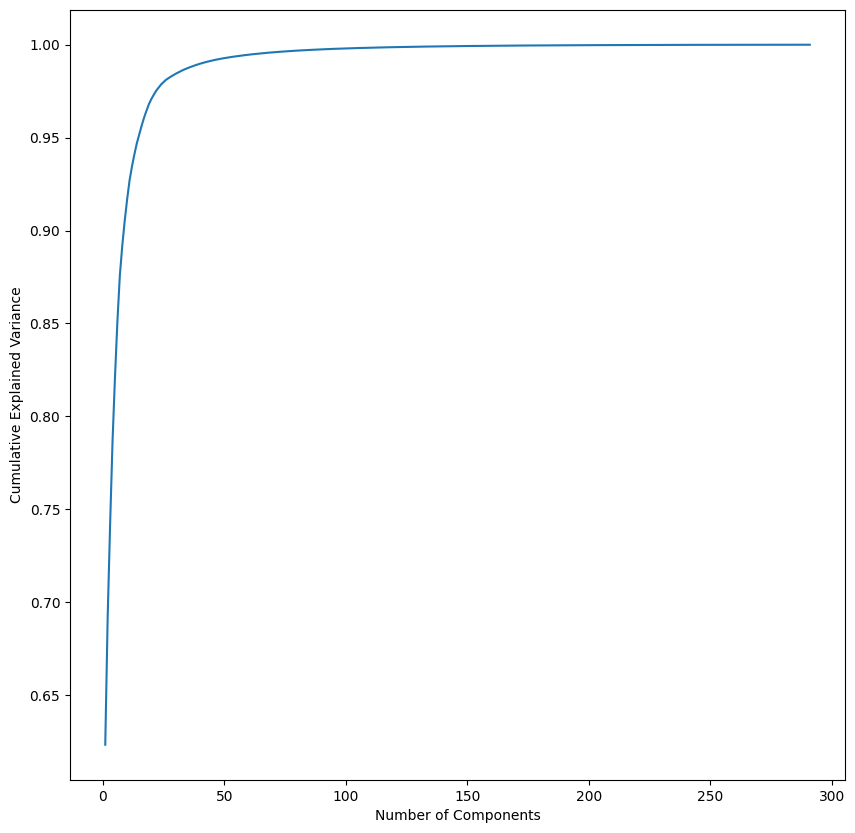

In [9]:
# Represents the 3. option (using PCA to reduce the dimensionality)
# First plot the cumulative variance ratio to decide the value of n_components=...
cumulative_variance_ratio = plot_cumulative_variance_ratio(X1, y1, figsize=(10, 10), fontsize=10)

In [10]:
# Lets take the number of components where we have a cumulative variance ratio of 99.9% (~133 components)
treshold = 0.999
n_components = None
for i, cvr in enumerate(cumulative_variance_ratio):
    if cvr >= treshold:
        n_components = i + 1
        break
print(f"n_components={n_components}")

n_components=133


In [11]:
# Lets perform PCA with the calculated n_components
X3 = PCA(n_components=n_components).fit_transform(X1)
y3 = y1.copy()

## Data Visualization

We can visualize the data and looking into the distribution of tpm_unstranded values of each gene by plotting a scatter matrix or a boxplot.
For simplicity we only plot the scatter matrix and boxplots for the first $N$ genes.

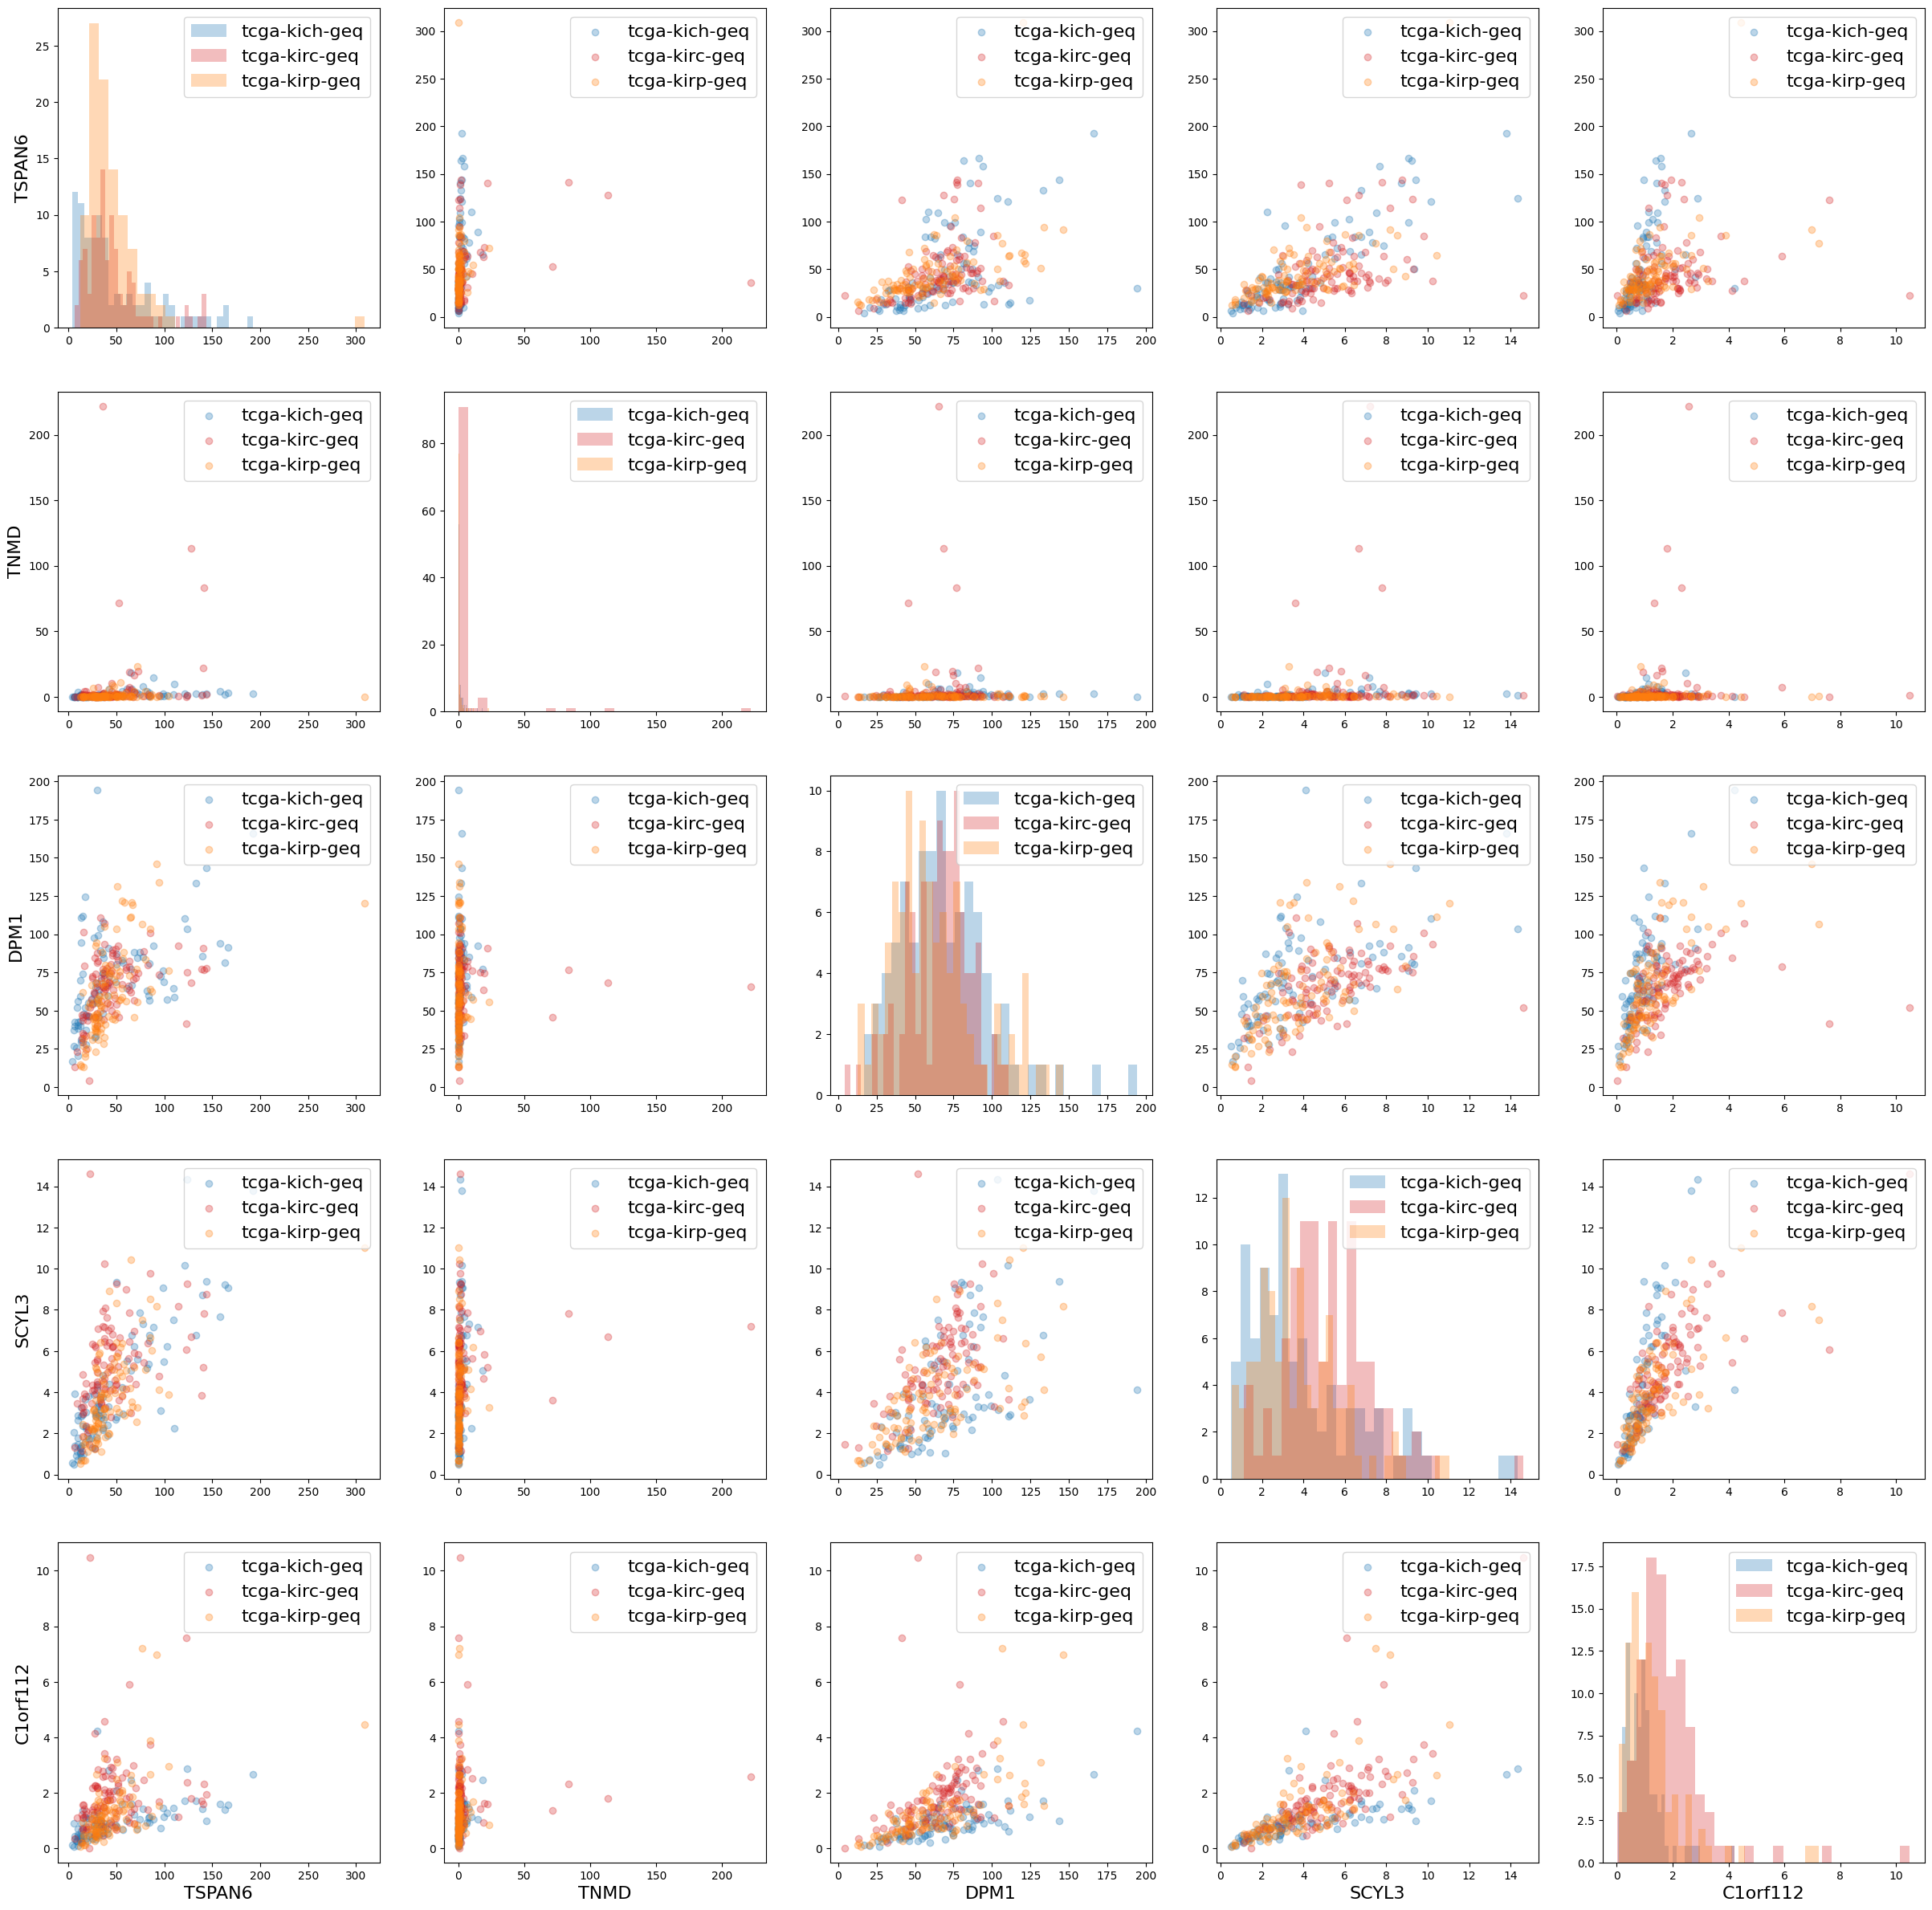

In [12]:
# Plot the scatter matrix plot
N_gene_visualize = 5
plot_scatter_matrix(X1[:, :N_gene_visualize], y1, labels, columns[:N_gene_visualize], figsize=(30, 30), fontsize=16)

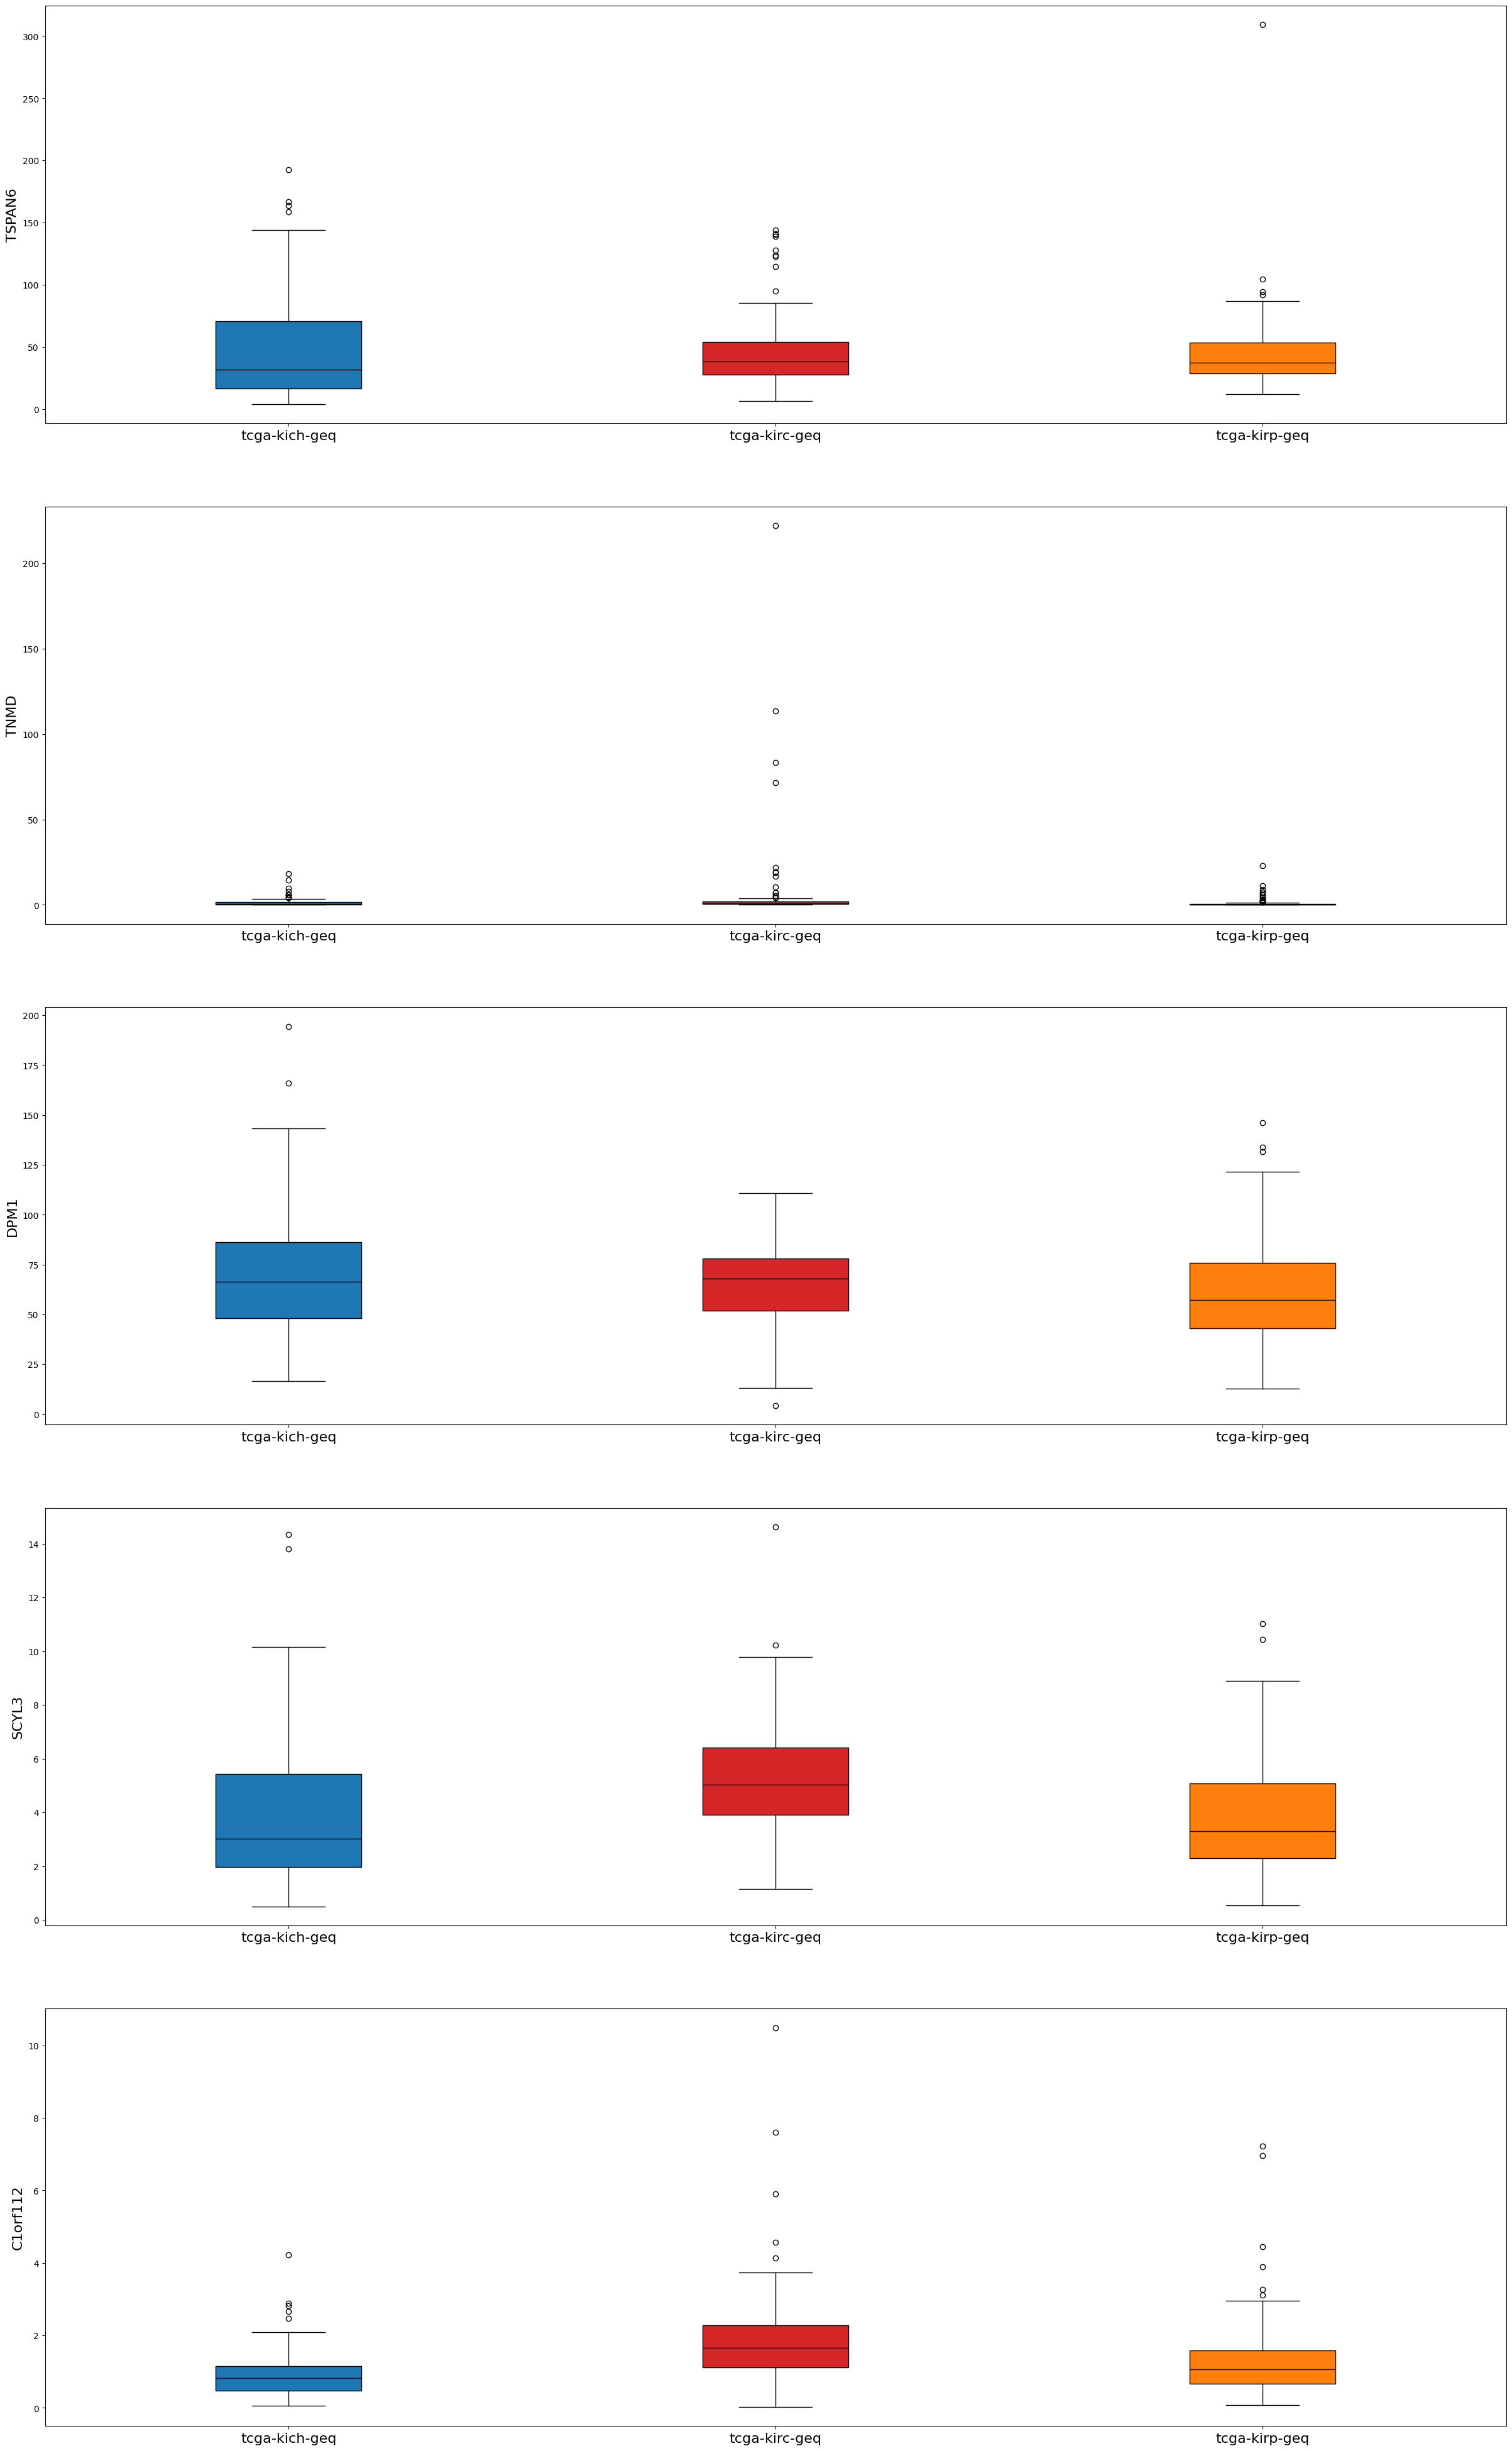

In [13]:
# Plot the boxplot for each gene between different classes
plot_boxplot(X1[:, :N_gene_visualize], y1, labels, columns[:N_gene_visualize], figsize=(30, 50), fontsize=16)

## Algorithm Selection & Training

We decide to use three different classifier models to solve the classification problem.
The three different classifier models are:
- (Single) Decision Trees (DTs)
- Random Forest (RFs)
- Multi-Layer Perceptron (MLPs)

For each model we define their hyperparameters and configuration space.
A configuration space is an object, where we define the valid bounds (continuous) and options (categorical) for each hyperparameter,
primarly to sample valid hyperparameters from it.

We decided to use a simple hyperparameter optimization technique which is called Random Search (RS).
The overall idea of RS is:
1. Sample a number of configurations (n_cfgs).
2. Evaluate each configuration with an metric (e. g. the accuracy)
3. Pick the configuration with the best metric (e. g. highest accuracy)

In [14]:
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch

class MLP(nn.Module):
    """
    A Multi-Layer Perceptron classifier model.

    Args:
        input_dim (int):
            The number of features
        
        hidden_dim (int):
            The number of hidden features
        
        output_dim (int):
            The number of output features
        
        n_hidden_layers (int):
            The number of hidden layers
        
        act_fn_type (str):
            The used activation function between each hidden layer
            If act_fn_type := 'relu': It uses nn.ReLU module as activation function
            If act_fn_type := 'sigmoid': It uses nn.Sigmoid as activation function
            If act_fn_type := 'tanh': It uses nn.Tanh as activation function
        
        loss_fn_type (str):
            The used loss function
            If loss_fn_type := 'ce': It uses nn.CrossEntropyLoss as loss function
        
        optimizer_fn_type (str):
            The used optimizer to update the parameters of the model
            If optimizer_fn_type := 'adam': It uses torch.optim.Adam as activation function
            If optimizer_fn_type := 'adamw': It uses torch.optim.AdamW as activation function
            If optimizer_fn_type := 'sgd': It uses torch.optim.SGD as activation function
            If optimizer_fn_type := 'rmsprop': It uses torch.optim.RMSprop as activation function
        
        lr (float):
            The learning rate of the optimizer
        
        batch_size (int):
            The number of samples for each batch
        
        n_epochs (int):
            The number of epochs to use for the training
        
        random_state (int):
            The random seed of the model
    """
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        n_hidden_layers: int,
        act_fn_type: str,
        loss_fn_type: str,
        optimizer_fn_type: str,
        lr: float,
        batch_size: int,
        n_epochs: int,
        random_state: int,
    ):
        # Sets the random state for pytorch / numpy
        torch.manual_seed(random_state)
        np.random.seed(random_state)
        
        super().__init__()
        layers = []  # list of all modules (including activation functions)
        act_fn_cls = self.get_act_fn(act_fn_type)  # class of activation function to use
        loss_fn_cls = self.get_loss_fn(loss_fn_type)  # class of loss function to use
        optimizer_fn_cls = self.get_optimizer_fn(optimizer_fn_type)  # class of optimizer to use

        if n_hidden_layers >= 1:
            # Case: There exist at least one hidden layer
            layer = nn.Linear(input_dim, hidden_dim)
            act_func = act_fn_cls()
            layers += [layer, act_func]
        
        for _ in range(n_hidden_layers - 1):
            # Case: Insert the other n-1 hidden layer
            layer = nn.Linear(hidden_dim, hidden_dim)
            act_func = act_fn_cls()
            layers += [layer, act_func]
        
        if n_hidden_layers >= 1:
            # Case: At least one hidden layer was used
            layers += [nn.Linear(hidden_dim, output_dim)]
        else:
            # Case: Not hidden layers are used
            layers += [nn.Linear(input_dim, output_dim)]
        
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.model = nn.Sequential(*layers)
        self.loss_fn = loss_fn_cls()
        self.optimizer = optimizer_fn_cls(params=self.model.parameters(), lr=lr)
    
    def forward(self, X: Union[np.ndarray, torch.Tensor]) -> torch.Tensor:
        """
        The forward pass of the MLP model.

        Args:
            X (Union[np.ndarray, torch.Tensor]):
                The feature matrix X of shape (NUM_SAMPLES, NUM_FEATURES)
        
        Returns:
            torch.Tensor:
                The predicted logits for each class y_logits of shape (NUM_SAMPLES, NUM_OUTPUTS)
        """
        if isinstance(X, np.ndarray):
            X_ = torch.from_numpy(X).to(dtype=torch.float32)
        else:
            X_ = X
        return self.model.forward(X_)
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Trains the MLP model for a given number of epochs.

        Args:
            X (np.ndarray):
                Feature matrix for training X_train of shape (NUM_SAMPLES, NUM_FEATURES)
            
            y (np.ndarray):
                Labels vector for training y_train of shape (NUM_SAMPLES,)
        
        Returns:
            np.ndarray:
                training losses over each epoch
        """
        self.model.train()

        # Create DataLoader for (mini-)batch training
        X_train = torch.from_numpy(X).to(dtype=torch.float32)
        y_train = torch.from_numpy(y).to(dtype=torch.int64)
        dataset = TensorDataset(X_train, y_train)
        dataloader = DataLoader(dataset=dataset, batch_size=self.batch_size, shuffle=True)
        train_losses = []
        
        for _ in range(self.n_epochs):
            running_loss = 0.0
            n = 0
            for _, (inputs, targets) in enumerate(dataloader):
                # Zero your gradients for every batch
                self.optimizer.zero_grad()
                
                # Make predictions for this batch
                outputs = self.model.forward(inputs)
                
                # Compute the loss and its gradients
                loss = self.loss_fn(outputs, targets)
                loss.backward()
                
                # Adjust learning weights
                self.optimizer.step()
                
                # Update running loss and number of batches
                running_loss += loss.item()
                n += 1
            
            # Compute loss of i-th epoch
            epoch_loss = running_loss / n
            train_losses += [epoch_loss]
        return np.array(train_losses)
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predicts the class labels, given new data points.

        Args:
            X (np.ndarray):
                The feature matrix of new unseen data points X_test
                of shape (NUM_SAMPLES, NUM_FEATURES)

        Returns:
            np.ndarray:
                The predicted class labels y_pred of shape (NUM_SAMPLES,)
       """
        self.model.eval()
        
        # Get the probability distribution over each class
        y_pred = self.forward(X)
        
        # Convert logits to probability distribution
        y_pred = y_pred.softmax(dim=1)
        
        # Select the class with the highest probability
        y_pred = y_pred.argmax(dim=1)
        
        # Convert to numpy array
        y_pred = y_pred.detach().cpu().numpy()
        
        return y_pred
    
    def get_act_fn(self, act_fn_type: str) -> Type[nn.Module]:
        """
        Returns the activation function (for each layer), given the type.

        Args:
            act_fn_type (str):
                The type of the activation function

        Returns:
            Type[nn.Module]:
                The class of the activation function
        """
        act_fns = {
            "relu": nn.ReLU,
            "sigmoid": nn.Sigmoid,
            "tanh": nn.Tanh,
        }
        if act_fn_type not in act_fns:
            raise ValueError(f"Unknown act_fn_type {act_fn_type}!")
        else:
            return act_fns[act_fn_type]
    
    def get_loss_fn(self, loss_fn_type: str) -> Type[nn.Module]:
        """
        Returns the loss function class, given the type.

        Args:
            loss_fn_type (str):
                Type of the loss function as string

        Returns:
            Type[nn.Module]:
                The class of the Loss function
        """
        loss_fns = {
            "ce": nn.CrossEntropyLoss,
        }
        if loss_fn_type not in loss_fn_type:
            raise ValueError(f"Unknown loss_fn_type {loss_fn_type}!")
        return loss_fns[loss_fn_type]

    def get_optimizer_fn(self, optimizer_fn_type: str) -> Type[torch.optim.Optimizer]:
        """
        Returns the optimizer class, given the type.

        Args:
            optimizer_fn_type (str):
                Type of the optimizer class as string

        Returns:
            Type[torch.optim.Optimizer]:
                The class of the optimizer
        """
        optimizer_fns = {
            "adam": torch.optim.Adam,
            "adamw": torch.optim.AdamW,
            "sgd": torch.optim.SGD,
            "rmsprop": torch.optim.RMSprop,
        }
        if optimizer_fn_type not in optimizer_fns:
            raise ValueError(f"Unknown optimizer_fn_type {optimizer_fn_type}!")
        return optimizer_fns[optimizer_fn_type]

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator
from ConfigSpace import ConfigurationSpace
import multiprocessing
import joblib

def eval_model(
    model: BaseEstimator,
    X: np.ndarray,
    y: np.ndarray,
    n_splits: int = 3, 
    random_state: int = 0
) -> float:
    """
    Evaluates a given Classifier, by K-Fold cross validation (CV).

    Args:
        model (BaseEstimator): 
            The classifier we want to evaluate
            
        X (np.ndarray):
            The feature vector of shape (N, ?)
            
        y (np.ndarray):
            The output class labels of shape (N, ?)
        
        n_splits (int, optional): 
            Number of splits for K-Fold cross validation
        
        random_state (int, optional):
            Random seed for the K-Fold cross validation (for reproducibility)

    Returns:
        float:
            Mean over the k-computed (balanced) accuracy scores
    """
    scores = []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    for train_idx, val_idx in kf.split(X):
        
        # Get the train/test dataset
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Evaluate the model with the accuracy
        y_pred = model.predict(X_val)
        score = balanced_accuracy_score(y_true=y_val, y_pred=y_pred)
        scores += [score]
    return np.mean(scores)

def eval_configuration(
    model_cls: Type[BaseEstimator],
    cfg: Configuration,
    X: np.ndarray,
    y: np.ndarray,
    n_splits: int = 3,
    model_random_state: int = 1,
    cv_random_state: int = 1,
) -> float:  
    """
    Evaluates a configuration (:= set of hyperparameters) to a given model class, by K-Fold cross validation (CV).

    Args:
        model_cls (Type[BaseEstimator]):
            The model class (:= classifier) we want to use
            
        cfg (Configuration):
            The configuration we want to evaluate
        
        X (np.ndarray):
            The feature vector of shape (N, ?)

        y (np.ndarray):
            The output class labels of shape (N, ?)
        
        n_splits (int, optional): 
            Number of splits for K-Fold cross validation
        
        model_random_state (int, optional):
            The random seed for the model
        
        cv_random_state (int, optional):
            The random seed for the K-Fold cross validation

    Returns:
        float:
            Mean over the k-computed (balanced) accuracy scores
    """
    model = model_cls(**cfg, random_state=model_random_state)
    return eval_model(model, X, y, n_splits=n_splits, random_state=cv_random_state)

def eval_final_configuration(
    model_cls: Type[BaseEstimator],
    cfg: Configuration,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    model_random_state: int = 1,
    return_y_pred: bool = True,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Evaluates the performance of the final configuration by (...)
        - using the training dataset (X_train, y_train) to train 
        the model with the given configuration
        
        - using the test dataset (X_test, y_test) to evaluate
        the final performance of the model with the given
        configuration

    Args:
        model_cls (Type[BaseEstimator]):
            The model class (:= classifier) we want to use
        
        cfg (Configuration):
            The configuration we want to evaluate
        
        X_train (np.ndarray):
            The feature vector of training dataset with shape (N1, ?)
        
        y_train (np.ndarray):
            The output class labels of training dataset with shape (N1, ?)
        
        X_test (np.ndarray):
            The feature vector of testing dataset with shape (N2, ?)
            
        y_test (np.ndarray):
            The output class labels of testing dataset with shape (N2, ?)
        
        model_random_state (int, optional):
            The random seed for the model
        
        return_y_pred (bool, optional):
            Controls if the predicted y-values (from X_test) should be returned

    Returns:
        tuple:
            scores (np.ndarray):
                accuracy (float):
                    The accuracy metric between the predicted y-values 
                    (extracted from X_test) and the true y-values (y_test)
                
                balanced_accuracy (float):
                    The balanced accuracy metric between the predicted y-values
                    (extracted from X_test) and the true y-values (y_test)
                
                f1_score (float):
                    The F1 score metric between the predicted y-values 
                    (extracted from X_test) and the true y-values (y_test)
            
            y_pred (np.ndarray):
                The predicted y-values from X_test
    """
    # Create the model with the configuration
    model = model_cls(**cfg, random_state=model_random_state)
    
    # Fit the model with the training dataset X_train, y_train
    model.fit(X_train, y_train)
    
    # Compute the predicted y_pred from the test dataset
    y_pred = model.predict(X_test)
    
    # Compute the accuracy, balanced accuracy and f1 score
    accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
    balanced_accuracy = balanced_accuracy_score(y_true=y_test, y_pred=y_pred)
    f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")

    if return_y_pred:
        return np.array([accuracy, balanced_accuracy, f1]), y_pred
    else:
        return np.array([accuracy, balanced_accuracy, f1])

def eval_final_configurations(
    model_cls: Type[BaseEstimator],
    cfgs: list[Configuration],
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    return_y_pred: bool = True,
):
    # Print the accuracy, balanced accuracy and f1 score of the DT model
    scores = np.zeros(shape=(len(cfgs), 3))  # shape := (NUM_SEEDS, 3)
    y_preds = np.zeros(shape=(len(cfgs), len(X_test)))  # shape := (NUM_SEEDS, NUM_SAMPLES)
    for i, cfg in enumerate(cfgs):
        scores[i], y_preds[i] = eval_final_configuration(model_cls, cfg, X_train, y_train, X_test, y_test, i, return_y_pred=True)

    if return_y_pred:
        return scores, y_preds
    else:
        return scores

def random_search(
    cs: ConfigurationSpace,
    X: np.ndarray,
    y: np.ndarray,
    n_cfgs: int = 50,
    n_seeds: int = 3,
) -> tuple[list[Configuration], np.ndarray]:
    """
    Performs Random Search for finding the best configuration.

    Args:
        cs (ConfigurationSpace):
            The configuration space from where we sample
        
        X (np.ndarray):
            The feature vector of shape (N, ?)
        
        y (np.ndarray):
            The output class labels of shape (N, ?)
        
        n_cfgs (int, optional):
            The number of configuration we want to evaluate/sample
        
        n_seeds (int, optional):
            The number of random seeds to use for the model/configuration space
    
    Returns:
        tuple:
            best_cfgs (list[Configuration]):
                The best founded configuration per random seed
                
            histories (np.ndarray)
                The accuracy of each sampled configuration per random seed
    """
    # Function to perform random search for a single seed
    def _random_search(seed: int) -> tuple[Configuration, list[float]]:
        """
        Performs a random search with one random seed.
        
        Args:
            seed (int):
                The random number for Configurationspace and random_state of the model

        Returns:
            tuple[Configuration, list[float]]:
                best_cfg (Configuration):
                    The best configuration seen so far
                
                histories (list[float]):
                    The list of performance for each sampled configuration
        """
        def _eval_configuration(cfg: Configuration) -> float:
            return eval_configuration(model_cls, cfg, X, y, n_splits, seed, cv_random_state)
        
        best_cfg = None

        # Get the meta data of the configuration space
        model_cls = cs.meta["model_class"]
        n_splits = cs.meta["n_splits"]
        cv_random_state = cs.meta["cv_random_state"]

        # Set the random state for the configuration space
        cs.seed(seed)

        # Sample the configurations
        cfgs = [cs.sample_configuration()] if n_cfgs == 1 else cs.sample_configuration(n_cfgs)

        # Perform Random Search in parallel for each configuration
        history = joblib.Parallel(n_jobs=multiprocessing.cpu_count())(joblib.delayed(_eval_configuration)(cfg) for cfg in cfgs)
        
        # Select the best configuration
        best_cfg = cfgs[np.argmax(history)]

        return best_cfg, history
    assert n_cfgs >= 1, f"Illegal n_cfgs {n_cfgs}. The argument should be higher or equal to 1!"
    assert n_seeds >= 1, f"Illegal n_seeds {n_seeds}. The argument should be higher or equal to 1!"
    
    best_cfgs = []
    histories = []
    
    # Run random search in parallel for each seed
    results = joblib.Parallel(n_jobs=multiprocessing.cpu_count())(joblib.delayed(_random_search)(seed) for seed in range(n_seeds))

    # Aggregate results
    best_cfgs = [result[0] for result in results]
    histories = [result[1] for result in results]
    return best_cfgs, np.array(histories)

In [16]:
from ConfigSpace import Integer, Categorical, Float, Constant
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Random seeds for specific operations
cv_random_state = 0
split_random_state = cv_random_state

# Initialize the Configuration Space for the DT model
dt_cs = ConfigurationSpace(
    space={
        "criterion": Categorical("criterion", items=["gini", "entropy", "log_loss"], default="gini"),
        "max_depth": Integer("max_depth", bounds=(1, 30), default=10),
        "min_samples_split": Integer("min_samples_split", bounds=(2, 10), default=2),
        "min_samples_leaf": Integer("min_samples_leaf", bounds=(1, 10), default=1),
        "max_features": Categorical("max_features", items=["sqrt", "log2"], default="sqrt"),
    },
    meta={
        "model_class": DecisionTreeClassifier,
        "n_splits": 3,
        "cv_random_state": cv_random_state,
    }
)

# Initialize the Configuration Space for the RF model
rf_cs = ConfigurationSpace(
    space={
        "n_estimators": Integer("n_estimators", bounds=(10, 30), default=20),
        "criterion": Categorical("criterion", items=["gini", "entropy", "log_loss"], default="gini"),
        "max_depth": Integer("max_depth", bounds=(1, 30), default=10),
        "min_samples_split": Integer("min_samples_split", bounds=(2, 10), default=2),
        "min_samples_leaf": Integer("min_samples_leaf", bounds=(1, 10), default=1),
        "max_features": Categorical("max_features", items=["sqrt", "log2"], default="sqrt"),
    },
    meta={
        "model_class": RandomForestClassifier,
        "n_splits": 3,
        "cv_random_state": cv_random_state,
    }
)

# Initialize the configuration space of the MLP model
# For every option we have to change the "input_dim" parameter from the configuration space!
mlp1_cs = ConfigurationSpace(
    space={
        "input_dim": Constant("input_dim", value=X1.shape[1]),
        "hidden_dim": Integer("hidden_dim", bounds=(16, 64), default=32),
        "output_dim": Constant("output_dim", value=3),
        "n_hidden_layers": Integer("n_hidden_layers", bounds=(0, 3), default=1),
        "act_fn_type": Categorical("act_fn_type", items=["relu", "sigmoid", "tanh"], default="relu"),
        "loss_fn_type": Constant("loss_fn_type", value="ce"),
        "optimizer_fn_type": Categorical("optimizer_fn_type", items=["adam", "adamw", "sgd", "rmsprop"], default="adam"),
        "lr": Float("lr", bounds=(1e-5, 1e-2), default=1e-3),
        "batch_size": Integer("batch_size", bounds=(16, 64), default=32),
        "n_epochs": Constant("n_epochs", value=200),
    },
    meta={
        "model_class": MLP,
        "n_splits": 3,
        "cv_random_state": cv_random_state,
    }
)

mlp2_cs = ConfigurationSpace(
    space={
        "input_dim": Constant("input_dim", value=X2.shape[1]),
        "hidden_dim": Integer("hidden_dim", bounds=(16, 64), default=32),
        "output_dim": Constant("output_dim", value=3),
        "n_hidden_layers": Integer("n_hidden_layers", bounds=(0, 3), default=1),
        "act_fn_type": Categorical("act_fn_type", items=["relu", "sigmoid", "tanh"], default="relu"),
        "loss_fn_type": Constant("loss_fn_type", value="ce"),
        "optimizer_fn_type": Categorical("optimizer_fn_type", items=["adam", "adamw", "sgd", "rmsprop"], default="adam"),
        "lr": Float("lr", bounds=(1e-5, 1e-2), default=1e-3),
        "batch_size": Integer("batch_size", bounds=(16, 64), default=32),
        "n_epochs": Constant("n_epochs", value=200),
    },
    meta={
        "model_class": MLP,
        "n_splits": 3,
        "cv_random_state": cv_random_state,
    }
)

mlp3_cs = ConfigurationSpace(
    space={
        "input_dim": Constant("input_dim", value=X3.shape[1]),
        "hidden_dim": Integer("hidden_dim", bounds=(16, 64), default=32),
        "output_dim": Constant("output_dim", value=3),
        "n_hidden_layers": Integer("n_hidden_layers", bounds=(0, 3), default=1),
        "act_fn_type": Categorical("act_fn_type", items=["relu", "sigmoid", "tanh"], default="relu"),
        "loss_fn_type": Constant("loss_fn_type", value="ce"),
        "optimizer_fn_type": Categorical("optimizer_fn_type", items=["adam", "adamw", "sgd", "rmsprop"], default="adam"),
        "lr": Float("lr", bounds=(1e-5, 1e-2), default=1e-3),
        "batch_size": Integer("batch_size", bounds=(16, 64), default=32),
        "n_epochs": Constant("n_epochs", value=200),
    },
    meta={
        "model_class": MLP,
        "n_splits": 3,
        "cv_random_state": cv_random_state,
    }
)

In [17]:
from sklearn.model_selection import train_test_split

# Split the data into train and test set
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=split_random_state)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=split_random_state)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=split_random_state)

In [18]:
# Do Random Search on DT model (~1 min.)
dt1_best_cfgs, dt1_histories = random_search(dt_cs, X1_train, y1_train, n_cfgs=50, n_seeds=3)
dt2_best_cfgs, dt2_histories = random_search(dt_cs, X2_train, y2_train, n_cfgs=50, n_seeds=3)
dt3_best_cfgs, dt3_histories = random_search(dt_cs, X3_train, y3_train, n_cfgs=50, n_seeds=3)

In [19]:
# Print the accuracy, balanced accuracy and f1 score of the DT model
dt1_scores, dt1_y_preds = eval_final_configurations(dt_cs.meta["model_class"], dt1_best_cfgs, X1_train, y1_train, X1_test, y1_test, return_y_pred=True)
dt2_scores, dt2_y_preds = eval_final_configurations(dt_cs.meta["model_class"], dt2_best_cfgs, X2_train, y2_train, X2_test, y2_test, return_y_pred=True)
dt3_scores, dt3_y_preds = eval_final_configurations(dt_cs.meta["model_class"], dt3_best_cfgs, X3_train, y3_train, X3_test, y3_test, return_y_pred=True)

# Accumulate across NUM_SEEDS
dt1_scores = np.mean(dt1_scores, axis=0)
dt2_scores = np.mean(dt2_scores, axis=0)
dt3_scores = np.mean(dt3_scores, axis=0)

print(f"Option 1: Acc. := {dt1_scores[0]}, Balanced Acc. := {dt1_scores[1]}, F1 Score := {dt1_scores[2]}")
print(f"Option 2: Acc. := {dt2_scores[0]}, Balanced Acc. := {dt2_scores[1]}, F1 Score := {dt2_scores[2]}")
print(f"Option 3: Acc. := {dt3_scores[0]}, Balanced Acc. := {dt3_scores[1]}, F1 Score := {dt3_scores[2]}")

Option 1: Acc. := 0.751412429378531, Balanced Acc. := 0.7621939464044728, F1 Score := 0.7553883943304393
Option 2: Acc. := 0.711864406779661, Balanced Acc. := 0.7364886575412891, F1 Score := 0.7102797757059295
Option 3: Acc. := 0.48022598870056504, Balanced Acc. := 0.48689030267977634, F1 Score := 0.48647055887575275


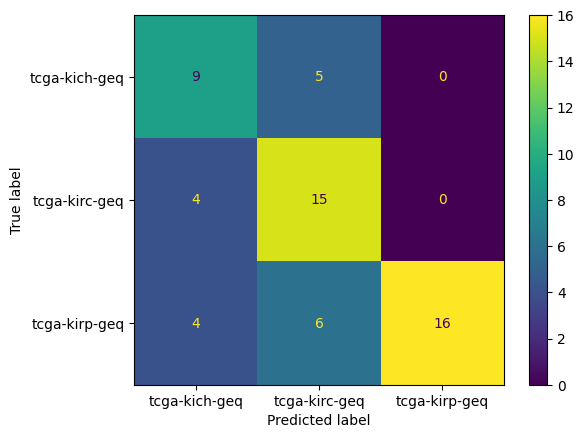

In [20]:
# Plot the confusion matrix of the first run
ConfusionMatrixDisplay.from_predictions(y_true=y1_test, y_pred=dt1_y_preds[0], display_labels=labels)

In [21]:
# Do Random Search on RF model (~3 min.)
rf1_best_cfgs, rf1_histories = random_search(rf_cs, X1_train, y1_train, n_cfgs=50, n_seeds=3)
rf2_best_cfgs, rf2_histories = random_search(rf_cs, X2_train, y2_train, n_cfgs=50, n_seeds=3)
rf3_best_cfgs, rf3_histories = random_search(rf_cs, X3_train, y3_train, n_cfgs=50, n_seeds=3)

In [22]:
# Print the accuracy, balanced accuracy and f1 score of the RF model
rf1_scores, rf1_y_preds = eval_final_configurations(rf_cs.meta["model_class"], rf1_best_cfgs, X1_train, y1_train, X1_test, y1_test, return_y_pred=True)
rf2_scores, rf2_y_preds = eval_final_configurations(rf_cs.meta["model_class"], rf2_best_cfgs, X2_train, y2_train, X2_test, y2_test, return_y_pred=True)
rf3_scores, rf3_y_preds = eval_final_configurations(rf_cs.meta["model_class"], rf3_best_cfgs, X3_train, y3_train, X3_test, y3_test, return_y_pred=True)

# Accumulate across NUM_SEEDS
rf1_scores = np.mean(rf1_scores, axis=0)
rf2_scores = np.mean(rf2_scores, axis=0)
rf3_scores = np.mean(rf3_scores, axis=0)

print(f"Option 1: Acc. := {rf1_scores[0]}, Balanced Acc. := {rf1_scores[1]}, F1 Score := {rf1_scores[2]}")
print(f"Option 2: Acc. := {rf2_scores[0]}, Balanced Acc. := {rf2_scores[1]}, F1 Score := {rf2_scores[2]}")
print(f"Option 3: Acc. := {rf3_scores[0]}, Balanced Acc. := {rf3_scores[1]}, F1 Score := {rf3_scores[2]}")

Option 1: Acc. := 0.8361581920903954, Balanced Acc. := 0.8587815693078852, F1 Score := 0.8356042871358139
Option 2: Acc. := 0.8135593220338982, Balanced Acc. := 0.8327870959449907, F1 Score := 0.8146691896688832
Option 3: Acc. := 0.6892655367231638, Balanced Acc. := 0.7083734978471821, F1 Score := 0.689901647389831


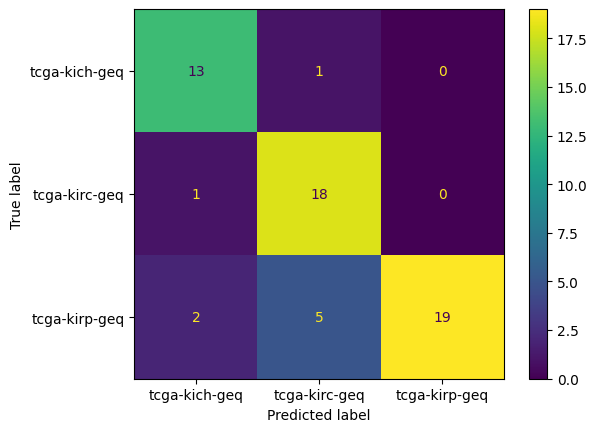

In [23]:
# Plot the confusion matrix of the first run
ConfusionMatrixDisplay.from_predictions(y_true=y1_test, y_pred=rf1_y_preds[0], display_labels=labels)

In [24]:
# Do Random Search (~6 hours )
mlp1_best_cfgs, mlp1_histories = random_search(mlp1_cs, X1_train, y1_train, n_cfgs=50, n_seeds=3)
mlp2_best_cfgs, mlp2_histories = random_search(mlp2_cs, X2_train, y2_train, n_cfgs=50, n_seeds=3)
mlp3_best_cfgs, mlp3_histories = random_search(mlp3_cs, X3_train, y3_train, n_cfgs=50, n_seeds=3)

In [25]:
# Print the accuracy, balanced accuracy and f1 score of the RF model
mlp1_scores, mlp1_y_preds = eval_final_configurations(mlp1_cs.meta["model_class"], mlp1_best_cfgs, X1_train, y1_train, X1_test, y1_test, return_y_pred=True)
mlp2_scores, mlp2_y_preds = eval_final_configurations(mlp2_cs.meta["model_class"], mlp2_best_cfgs, X2_train, y2_train, X2_test, y2_test, return_y_pred=True)
mlp3_scores, mlp3_y_preds = eval_final_configurations(mlp3_cs.meta["model_class"], mlp3_best_cfgs, X3_train, y3_train, X3_test, y3_test, return_y_pred=True)

# Accumulate across NUM_SEEDS
mlp1_scores = np.mean(mlp1_scores, axis=0)
mlp2_scores = np.mean(mlp2_scores, axis=0)
mlp3_scores = np.mean(mlp3_scores, axis=0)

print(f"Option 1: Acc. := {mlp1_scores[0]}, Balanced Acc. := {mlp1_scores[1]}, F1 Score := {mlp1_scores[2]}")
print(f"Option 2: Acc. := {mlp2_scores[0]}, Balanced Acc. := {mlp2_scores[1]}, F1 Score := {mlp2_scores[2]}")
print(f"Option 3: Acc. := {mlp3_scores[0]}, Balanced Acc. := {mlp3_scores[1]}, F1 Score := {mlp3_scores[2]}")

Option 1: Acc. := 0.847457627118644, Balanced Acc. := 0.8652400231347599, F1 Score := 0.8474365450095974
Option 2: Acc. := 0.7966101694915254, Balanced Acc. := 0.790148448043185, F1 Score := 0.7948645596745642
Option 3: Acc. := 0.7909604519774011, Balanced Acc. := 0.8015230383651435, F1 Score := 0.7906519767754148


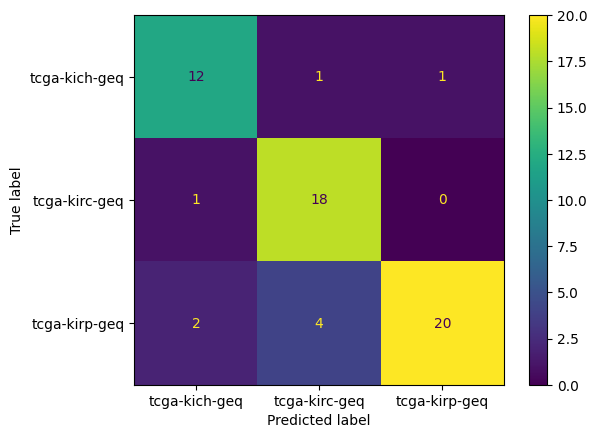

In [26]:
# Plot the confusion matrix of the first run
ConfusionMatrixDisplay.from_predictions(y_true=y1_test, y_pred=mlp1_y_preds[0], display_labels=labels)

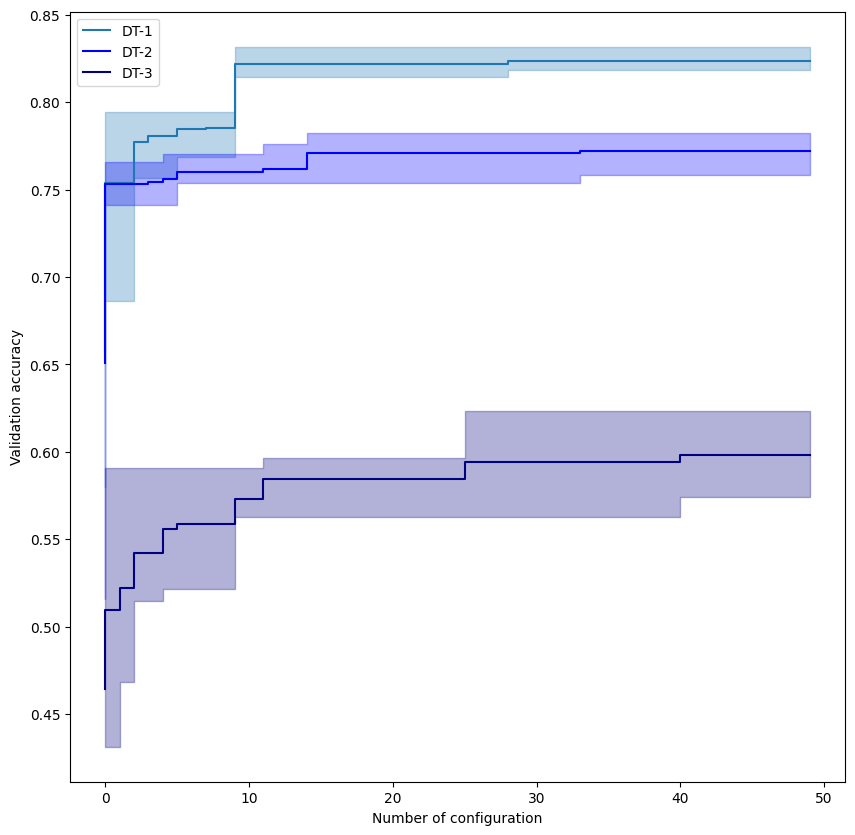

In [27]:
# Compare the DT models of each option
histories = np.stack([dt1_histories, dt2_histories, dt3_histories])

# Plot the incumbent improvement of the models
plot_incumbent_improvement(
    histories, 
    labels=["DT-1", "DT-2", "DT-3"],
    uncertainty_fn="min_max", 
    colors=["tab:blue", "blue", "navy"], 
    figsize=(10, 10), 
    fontsize=10,
)

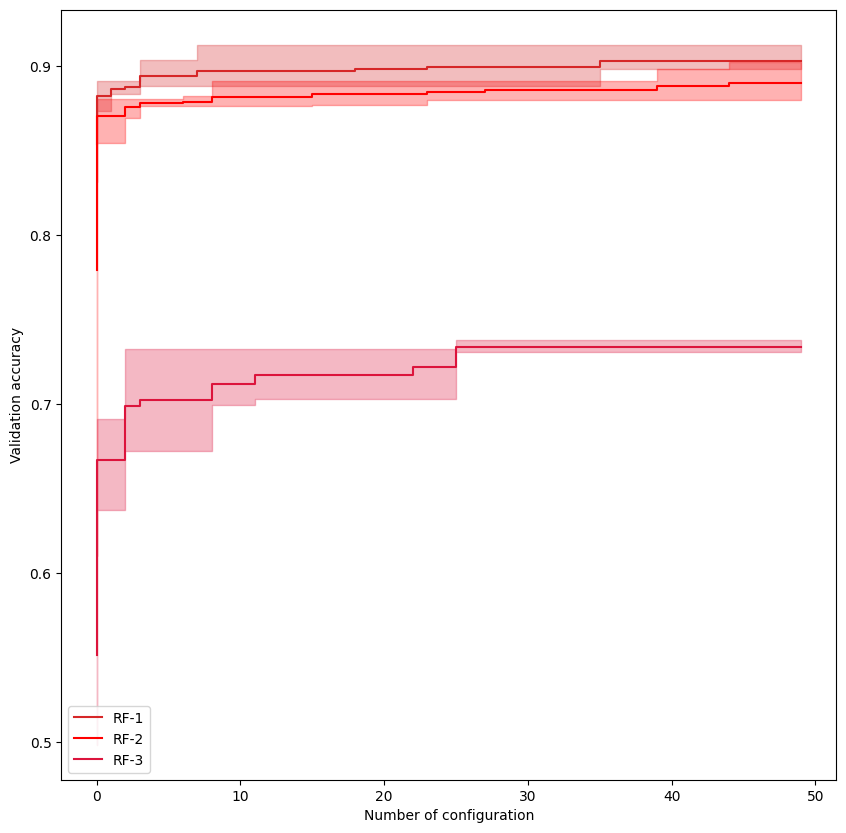

In [28]:
# Compare the RF models of each option
histories = np.stack([rf1_histories, rf2_histories, rf3_histories])

# Plot the incumbent improvement of the models
plot_incumbent_improvement(
    histories, 
    labels=["RF-1", "RF-2", "RF-3"],
    uncertainty_fn="min_max", 
    colors=["tab:red", "red", "crimson"], 
    figsize=(10, 10), 
    fontsize=10,
)

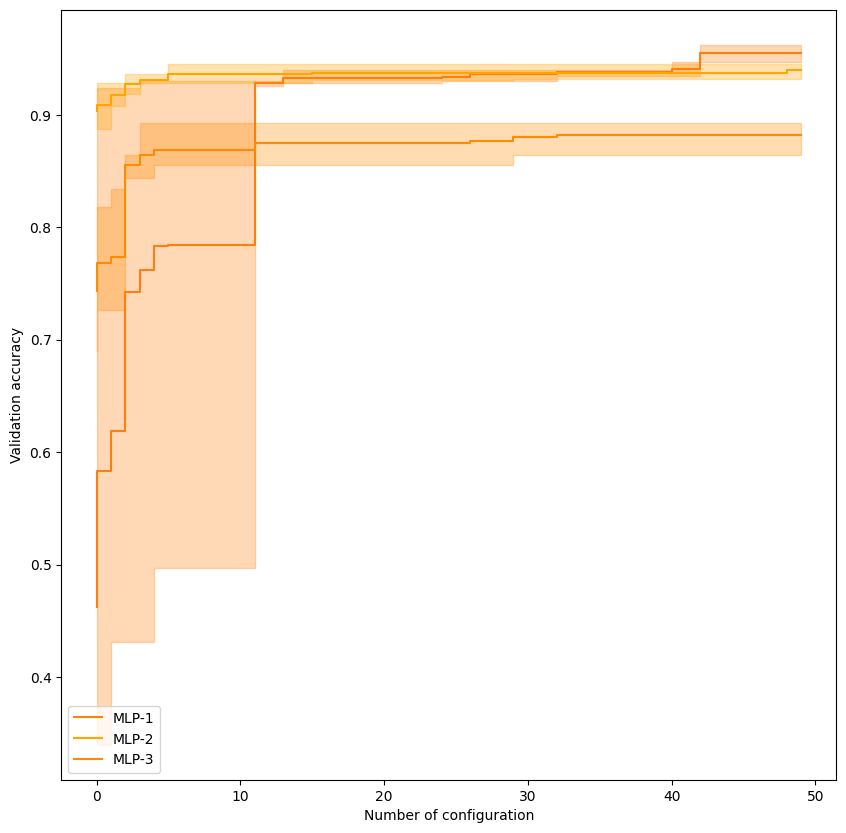

In [29]:
# Compare the MLP models of each option
histories = np.stack([mlp1_histories, mlp2_histories, mlp3_histories])

# Plot the incumbent improvement of the models
plot_incumbent_improvement(
    histories, 
    labels=["MLP-1", "MLP-2", "MLP-3"],
    uncertainty_fn="min_max", 
    colors=["tab:orange", "orange", "darkorange"], 
    figsize=(10, 10), 
    fontsize=10,
)

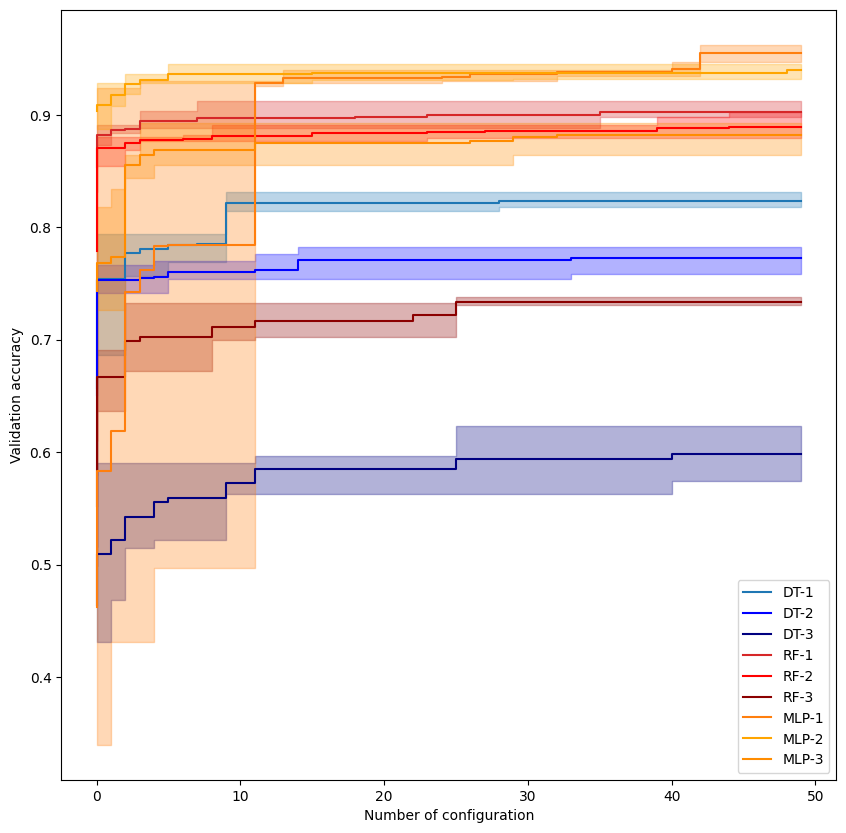

In [30]:
# Stack the histories of each (model, option) together to shape (NUM_MODELS, NUM_SEEDS, NUM_CFGS)
histories = np.stack([
    dt1_histories, dt2_histories, dt3_histories, 
    rf1_histories, rf2_histories, rf3_histories, 
    mlp1_histories, mlp2_histories, mlp3_histories
])

# Plot the incumbent improvement of the models
plot_incumbent_improvement(
    histories, 
    labels=["DT-1", "DT-2", "DT-3", "RF-1", "RF-2", "RF-3", "MLP-1", "MLP-2", "MLP-3"],
    uncertainty_fn="min_max", 
    colors=["tab:blue", "blue", "navy", 
            "tab:red", "red", "darkred", 
            "tab:orange", "orange", "darkorange"], 
    figsize=(10, 10), 
    fontsize=10,
)

In [31]:
# Create the training losses for the first run
training_losses = np.zeros(shape=(len(mlp1_best_cfgs), mlp1_cs["n_epochs"].value))  # shape (NUM_SEEDS, NUM_EPOCHS)
for i, best_cfg in enumerate(mlp1_best_cfgs):
    # Initialize the model
    model = MLP(**best_cfg, random_state=i)
    training_losses[i] = model.fit(X1_train, y1_train)

print(training_losses.shape)

(3, 200)


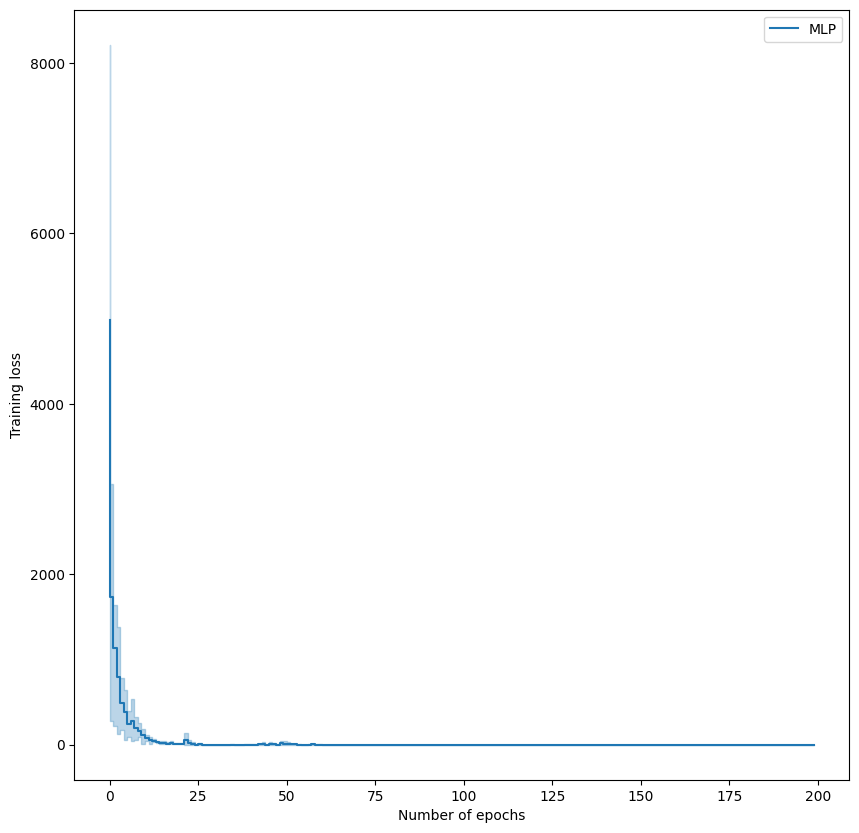

In [32]:
# Plot the learning curve of the MLP model
plot_learning_curve(training_losses, labels="MLP", uncertainty_fn="min_max", colors="tab:blue", figsize=(10, 10), fontsize=10)

The final performance of each model is summarized here:

Option 1:
| Model                        | Accuracy | Balanced Accuracy | F1-Score |
|------------------------------|----------|-------------------|----------|
| Decision Tree (DT)           | 0.751    | 0.762             | 0.755    |
| Random Forest (RF)           | 0.836    | 0.859             | 0.836    |
| Multi-Layer Perceptron (MLP) | 0.847    | 0.865             | 0.847    |

Option 2:
| Model                        | Accuracy | Balanced Accuracy | F1-Score |
|------------------------------|----------|-------------------|----------|
| Decision Tree (DT)           | 0.712    | 0.736             | 0.710    |
| Random Forest (RF)           | 0.813    | 0.833             | 0.815    |
| Multi-Layer Perceptron (MLP) | 0.797    | 0.790             | 0.795    |

Option 3:
| Model                        | Accuracy | Balanced Accuracy | F1-Score |
|------------------------------|----------|-------------------|----------|
| Decision Tree (DT)           | 0.480    | 0.487             | 0.486    |
| Random Forest (RF)           | 0.689    | 0.708             | 0.690    |
| Multi-Layer Perceptron (MLP) | 0.791    | 0.802             | 0.791    |

The training time (including HPO) is summarized here:

Option 1:
| Model                        | Time (sec)|
|------------------------------|------------|
| Decision Tree (DT)           | 39.0       |
| Random Forest (RF)           | 63.2       |
| Multi-Layer Perceptron (MLP) | 21628.3    |

Option 2:
| Model                        | Time (sec) |
|------------------------------|----------|
| Decision Tree (DT)           | 5.5      |
| Random Forest (RF)           | 20.0     |
| Multi-Layer Perceptron (MLP) | 1003.9   |

Option 3:
| Model                        | Time (sec) |
|------------------------------|------------|
| Decision Tree (DT)           | 4.8        |
| Random Forest (RF)           | 23.1       |
| Multi-Layer Perceptron (MLP) | 1111.9     |

The performance of DT and RF significantly drops by using PCA as dimension reduction method, where the MLP still lies around the ~80% accuracy.
Also we can see the big advantage of using DTs and RFs in balanced dataset. They can directly find out the most important genes, without using Dimensionality Reduction methods like PCA.
Also what we can see is that the random forest has a similar performance to the MLP model, but the RF training was much faster than the MLP ones.
Therefore it should be prefered to use a much simpler ML model than MLPs to solve this task.